# Planar Maximally Filtered Graph

In [1]:
import networkx as nx
import dynetx as dn
import numpy as np
import collections
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from sklearn.metrics import r2_score
from conformity import attribute_conformity
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from PIL import Image
%matplotlib inline

In [2]:
def sort_graph_edges(G):
    sorted_edges = []
    for source, dest, data in sorted(G.edges(data=True),
                                     key=lambda x: x[2]['weight']):
        sorted_edges.append({'source': source,
                             'dest': dest,
                             'weight': data['weight']})
        
    return sorted_edges

In [3]:
def compute_PMFG(G):
    sorted_edges = sort_graph_edges(G)
    nb_nodes = len(G.nodes())
    PMFG = nx.Graph()
    for edge in sorted_edges:
        PMFG.add_edge(edge['source'], edge['dest'])
        if not nx.is_planar(PMFG):
            PMFG.remove_edge(edge['source'], edge['dest'])
            
        if len(PMFG.edges()) == 3*(nb_nodes-2):
            break
    
    return PMFG

In [4]:
def draw_graph(G, title):
    """
    This function make and save plot of a graph

    Args:
        G (networkx.classes.graph.Graph): Graph
        name (string): name of the title
        map_color = if use cmap
    """    
    f = plt.figure(1, figsize=(10, 8))
    pos = nx.spring_layout(G, seed=7)
    ec = nx.draw_networkx_edges(G, pos, width = 0.5, edge_color='blue')
    nc = nx.draw_networkx_nodes(G, pos, node_color='red',
                                edgecolors = 'black',
                                node_shape = '.',
                                 node_size=5)
    nx.draw_networkx_labels(G, pos, font_size=6, font_color="black")
    f.set_facecolor('w')
    plt.axis('off')
    plt.title(f"{title}")

In [5]:
list_graph = np.load('data\\list_graph.npy',allow_pickle='TRUE').item()

In [6]:
for element in list(list_graph.keys()):
    list_graph[element] = compute_PMFG(list_graph[element])
    print(f'Done {element+1}/{len(list_graph)}')

Done 1/4
Done 2/4
Done 3/4
Done 4/4


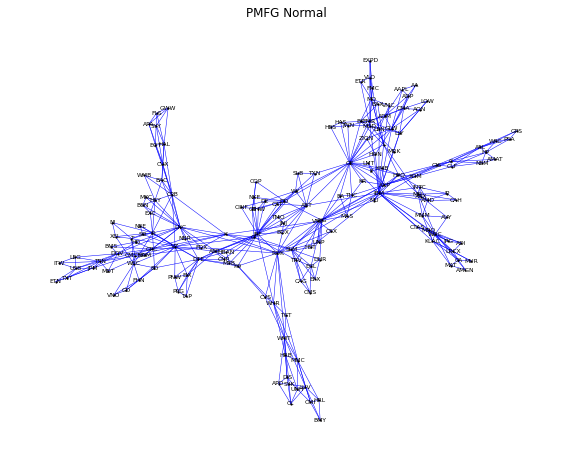

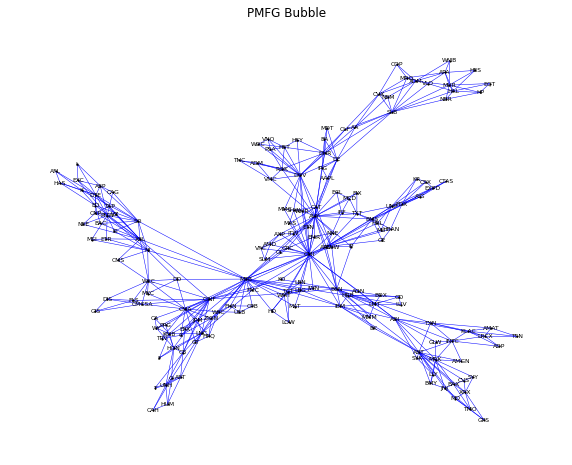

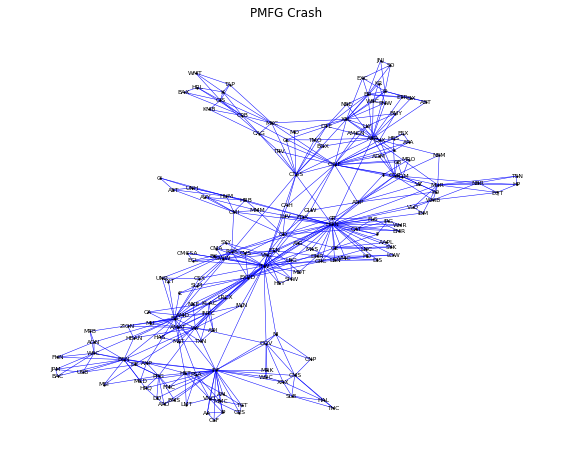

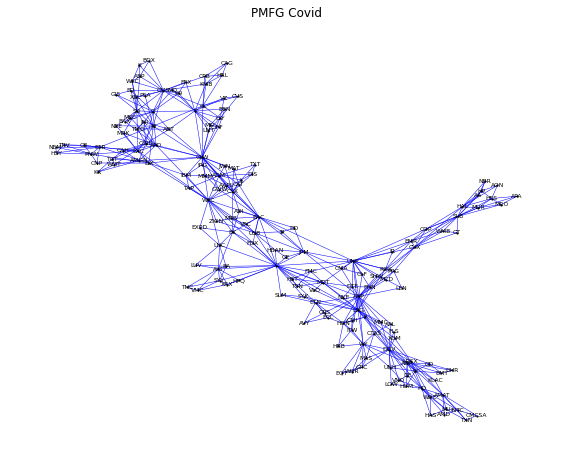

In [7]:
name_title = ['PMFG Normal', 'PMFG Bubble', 'PMFG Crash', 'PMFG Covid']
for index in range(0,4):
    f = draw_graph(list_graph[index], title = name_title[index])
    plt.savefig(f"plots\\{name_title[index]}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# Analysis

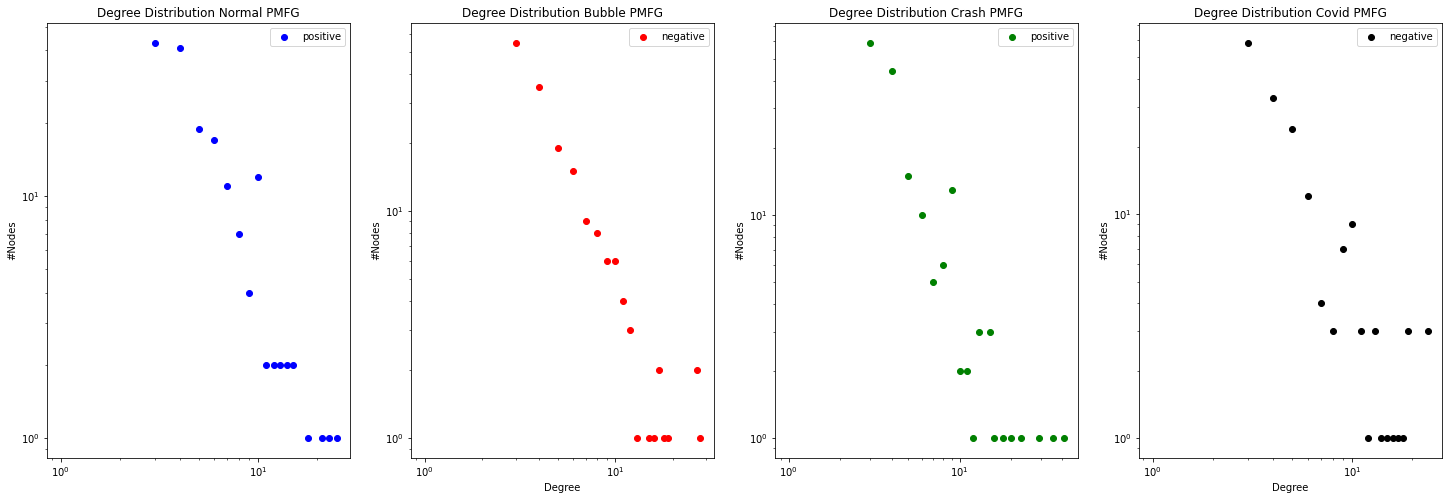

In [8]:
hist_normal = nx.degree_histogram(list_graph[0])
hist_bubble = nx.degree_histogram(list_graph[1])
hist_crash = nx.degree_histogram(list_graph[2])
hist_covid = nx.degree_histogram(list_graph[3])
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(25, 8))
ax1.plot(range(0, len(hist_normal)),hist_normal, linestyle=" ", label = 'positive', marker = 'o', color = 'blue')
ax1.set_title('Degree Distribution Normal PMFG')
ax1.legend()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('#Nodes')
ax2.plot(range(0, len(hist_bubble)),hist_bubble, linestyle=" ", label = 'negative', marker = 'o', color = 'red')
ax2.set_title('Degree Distribution Bubble PMFG')
ax2.set_xlabel('Degree')
ax2.set_ylabel('#Nodes')
ax2.legend()
ax2.loglog()
ax3.plot(range(0, len(hist_crash)),hist_crash, linestyle=" ", label = 'positive', marker = 'o', color = 'green')
ax3.set_title('Degree Distribution Crash PMFG')
ax3.legend()
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylabel('#Nodes')
ax4.plot(range(0, len(hist_covid)),hist_covid, linestyle=" ", label = 'negative', marker = 'o', color = 'black')
ax4.set_title('Degree Distribution Covid PMFG')
ax4.set_xlabel('Degree')
ax4.set_ylabel('#Nodes')
ax4.legend()
ax4.loglog()
plt.savefig("plots\\degree_distribution_PMFG.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [9]:
def fit_power_law_linear(x, y, init):
    opt_parms, parm_cov =curve_fit(powerlaw_fun_linear, x, y, init,maxfev=1000)
    A, B  = opt_parms
    return A, B, parm_cov
def powerlaw_fun_linear(x, A, B):
    return A +B*x

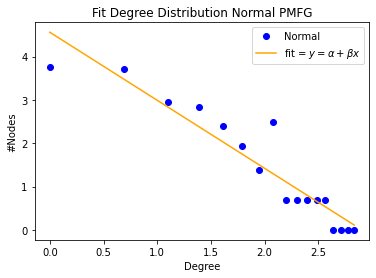

A: 4.56+-0.30, 	 B: -1.57+-0.14, 	 R2: 0.89, 	 chi: 0.9999018579365797


In [10]:
# Actual parameters
ydata = np.array(hist_normal)
ydata = np.log(ydata[ydata >0])
xdata = np.array(range(0, len(ydata)+1))
xdata = np.log(xdata[xdata >0])
init = (100,1.5)
A, B, parm_cov = fit_power_law_linear(xdata, ydata, init)
SE = np.sqrt(np.diag(parm_cov))
x_fit = np.linspace(min(xdata),max(xdata),10000)
fit_y = powerlaw_fun_linear(xdata, A, B )
y_fit = powerlaw_fun_linear(x_fit, A, B)
plt.plot(figsize=(20, 8))
plt.plot(xdata, ydata, marker = 'o', color = 'blue', label='Normal', linestyle=" ")
plt.plot(x_fit, y_fit, '-', label=r'fit = $y = \alpha + \beta x$'
         , color ='orange')
plt.legend()
plt.title('Fit Degree Distribution Normal PMFG')
plt.ylabel('#Nodes')
plt.xlabel('Degree')
plt.savefig("plots\\degree_distribution_normal_PMFG.pdf", format="pdf", bbox_inches="tight")
plt.show()
R2 = r2_score(ydata,fit_y)
chisq = chisquare(f_obs = ydata, f_exp=fit_y)
print(f'A: {A:.2f}+-{SE[0]:.2f}, \t B: {B:.2f}+-{SE[1]:.2f}, \t R2: {R2:.2f}, \t chi: {chisq[1]:}')

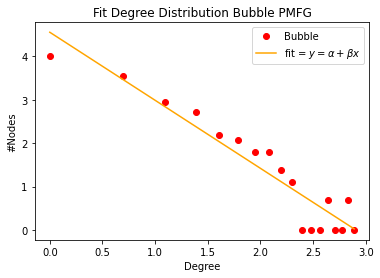

A: 4.56+-0.28, 	 B: -1.57+-0.13, 	 R2: 0.90, 	 chi: 0.9916853194067113


In [11]:
# Actual parameters
ydata = np.array(hist_bubble)
ydata = np.log(ydata[ydata >0])
xdata = np.array(range(0, len(ydata)+1))
xdata = np.log(xdata[xdata >0])
init = (100,1.5)
A, B, parm_cov = fit_power_law_linear(xdata, ydata, init)
SE = np.sqrt(np.diag(parm_cov))
x_fit = np.linspace(min(xdata),max(xdata),10000)
fit_y = powerlaw_fun_linear(xdata, A, B )
y_fit = powerlaw_fun_linear(x_fit, A, B)
plt.plot(figsize=(20, 8))
plt.plot(xdata, ydata, marker = 'o', color = 'red', label='Bubble', linestyle=" ")
plt.plot(x_fit, y_fit, '-', label=r'fit = $y = \alpha + \beta x$'
         , color ='orange')
plt.legend()
plt.title('Fit Degree Distribution Bubble PMFG')
plt.ylabel('#Nodes')
plt.xlabel('Degree')
plt.savefig("plots\\degree_distribution_bubble_PMFG.pdf", format="pdf", bbox_inches="tight")
plt.show()
R2 = r2_score(ydata,fit_y)
chisq = chisquare(f_obs = ydata, f_exp=fit_y)
print(f'A: {A:.2f}+-{SE[0]:.2f}, \t B: {B:.2f}+-{SE[1]:.2f}, \t R2: {R2:.2f}, \t chi: {chisq[1]:}')

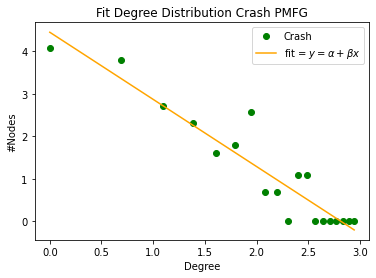

A: 4.45+-0.30, 	 B: -1.58+-0.14, 	 R2: 0.89, 	 chi: 0.9998458650302818


In [12]:
# Actual parameters
ydata = np.array(hist_crash)
ydata = np.log(ydata[ydata >0])
xdata = np.array(range(0, len(ydata)+1))
xdata = np.log(xdata[xdata >0])
init = (100,1.5)
A, B, parm_cov = fit_power_law_linear(xdata, ydata, init)
SE = np.sqrt(np.diag(parm_cov))
x_fit = np.linspace(min(xdata),max(xdata),10000)
fit_y = powerlaw_fun_linear(xdata, A, B )
y_fit = powerlaw_fun_linear(x_fit, A, B)
plt.plot(figsize=(20, 8))
plt.plot(xdata, ydata, marker = 'o', color = 'green', label='Crash', linestyle=" ")
plt.plot(x_fit, y_fit, '-', label=r'fit = $y = \alpha + \beta x$'
         , color ='orange')
plt.legend()
plt.title('Fit Degree Distribution Crash PMFG')
plt.ylabel('#Nodes')
plt.xlabel('Degree')
plt.savefig("plots\\degree_distribution_crash_PMFG.pdf", format="pdf", bbox_inches="tight")
plt.show()
R2 = r2_score(ydata,fit_y)
chisq = chisquare(f_obs = ydata, f_exp=fit_y)
print(f'A: {A:.2f}+-{SE[0]:.2f}, \t B: {B:.2f}+-{SE[1]:.2f}, \t R2: {R2:.2f}, \t chi: {chisq[1]:}')

In [13]:
def draw_net(G, measures, measure_name):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(15,15))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys(), edgecolors = 'black')
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.1, linscale=10, base=10))
    labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

### Clustering Coefficient and Density

In [14]:
density_normal = nx.density(list_graph[0])
density_bubble = nx.density(list_graph[1])
density_crash = nx.density(list_graph[2])
density_covid = nx.density(list_graph[3])
print(f'Normal density: {density_normal:.2f} \t Bubble density: {density_bubble:.2f}'
      f'\t Crash density: {density_crash:.2f} \t Covid density: {density_covid:.2f}')

Normal density: 0.04 	 Bubble density: 0.04	 Crash density: 0.04 	 Covid density: 0.04


In [15]:
CC_normal = nx.average_clustering(list_graph[0])
CC_bubble = nx.average_clustering(list_graph[1])
CC_crash = nx.average_clustering(list_graph[2])
CC_covid = nx.average_clustering(list_graph[3])
print(f'Global Clustering Coefficient Normal: {CC_normal:.3f} \t Global Clustering Coefficient Bubble: {CC_bubble:.3f}'
      f'\t Global Clustering Coefficient Crash: {CC_crash:.3f} \t Global Clustering Coefficient Covid: {CC_covid:.3f} ')

Global Clustering Coefficient Normal: 0.685 	 Global Clustering Coefficient Bubble: 0.721	 Global Clustering Coefficient Crash: 0.750 	 Global Clustering Coefficient Covid: 0.735 


In [16]:
list_clustering_normal = collections.defaultdict(list)
list_clustering_bubble = collections.defaultdict(list)
list_clustering_crash = collections.defaultdict(list)
list_clustering_covid = collections.defaultdict(list)
for node in list_graph[0].nodes():
    a = nx.clustering(list_graph[0])[node]
    list_clustering_normal[node] = a
    print(f'Done Normal {node}')
#np.save('normal_clustering.npy', list_clustering_normal) 
for node in list_graph[1].nodes():
    a = nx.clustering(list_graph[1])[node]
    list_clustering_bubble[node] = a
    print(f'Done Bubble {node}')
#np.save('bubble_clustering.npy', list_clustering_bubble)
for node in list_graph[2].nodes():
    a = nx.clustering(list_graph[2])[node]
    list_clustering_crash[node] = a
    print(f'Done Crash {node}')
#np.save('crash_clustering.npy', list_clustering_crash)
for node in list_graph[3].nodes():
    a = nx.clustering(list_graph[3])[node]
    list_clustering_covid[node] = a
    print(f'Done Covid {node}')
#np.save('covid_clustering.npy', list_clustering_covid) 

Done Normal VZ
Done Normal ED
Done Normal AMD
Done Normal MSI
Done Normal T
Done Normal IBM
Done Normal D
Done Normal SO
Done Normal DTE
Done Normal VFC
Done Normal ROK
Done Normal IFF
Done Normal AEP
Done Normal WEC
Done Normal XEL
Done Normal FDX
Done Normal AIG
Done Normal GE
Done Normal DD
Done Normal K
Done Normal LNC
Done Normal WHR
Done Normal CVS
Done Normal HPQ
Done Normal MCD
Done Normal MO
Done Normal INTC
Done Normal EIX
Done Normal CMCSA
Done Normal CI
Done Normal AXP
Done Normal THC
Done Normal F
Done Normal NEE
Done Normal MMC
Done Normal LUV
Done Normal MRO
Done Normal ADI
Done Normal PNW
Done Normal GPC
Done Normal ADM
Done Normal CMA
Done Normal MMM
Done Normal CPB
Done Normal GLW
Done Normal WY
Done Normal ABT
Done Normal LEN
Done Normal VMC
Done Normal AAPL
Done Normal ADP
Done Normal MUR
Done Normal LRCX
Done Normal MU
Done Normal WMT
Done Normal CLF
Done Normal NEM
Done Normal BA
Done Normal UNP
Done Normal HD
Done Normal L
Done Normal BAX
Done Normal WMB
Done Nor

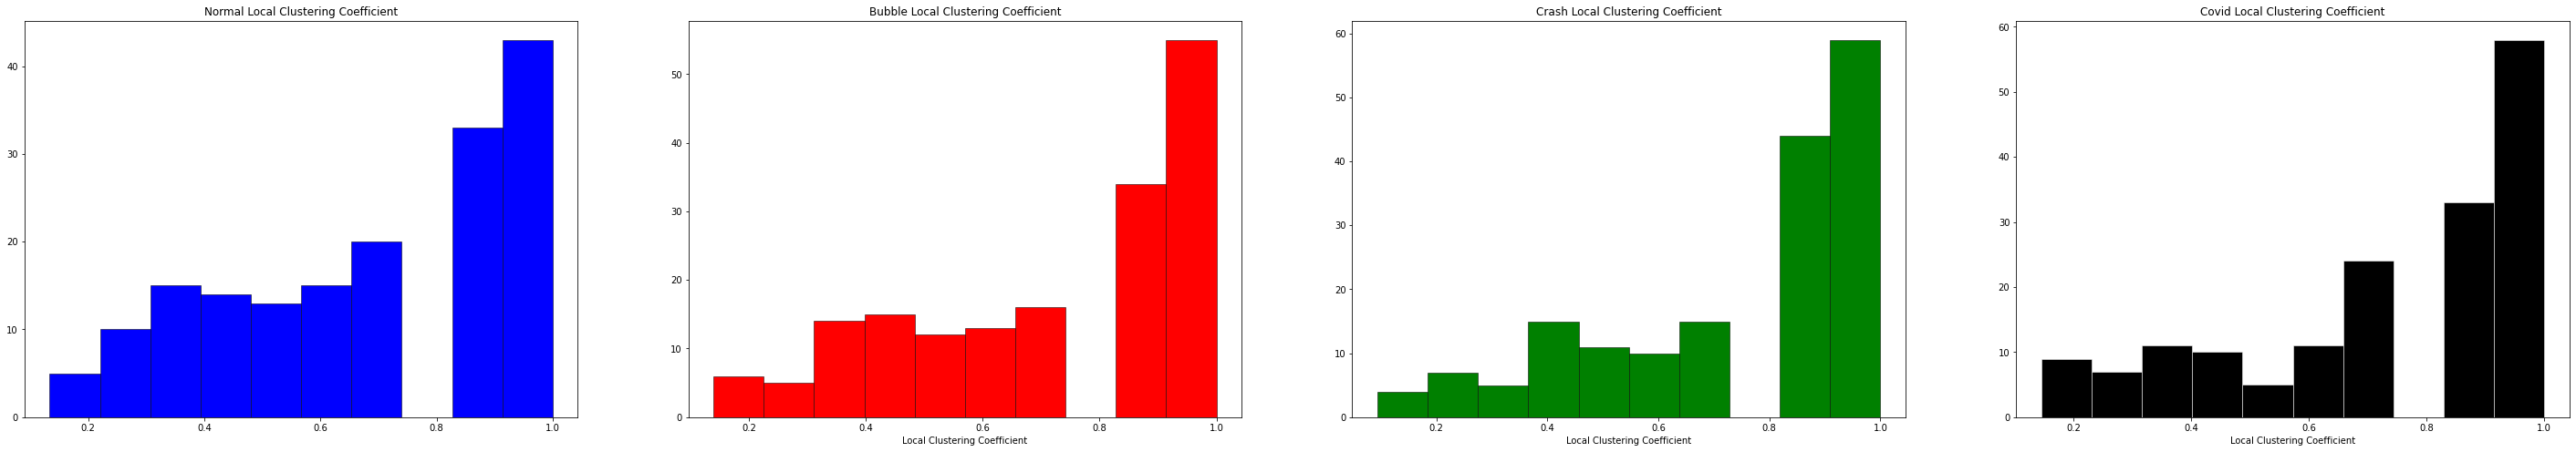

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(50, 8))
ax1.hist(list_clustering_normal.values(),facecolor = 'blue', edgecolor='black', linewidth=0.5)
ax1.set_title('Normal Local Clustering Coefficient')
ax2.hist(list_clustering_bubble.values(),facecolor = 'red', edgecolor='black', linewidth=0.5)
ax2.set_title('Bubble Local Clustering Coefficient')
ax2.set_xlabel('Local Clustering Coefficient')
ax3.hist(list_clustering_crash.values(),facecolor = 'green', edgecolor='black', linewidth=0.5)
ax3.set_title('Crash Local Clustering Coefficient')
ax3.set_xlabel('Local Clustering Coefficient')
ax4.hist(list_clustering_covid.values(),facecolor = 'black', edgecolor='white', linewidth=0.5)
ax4.set_title('Covid Local Clustering Coefficient')
ax4.set_xlabel('Local Clustering Coefficient')
#plt.savefig("plots\\local_clustering_coefficient.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Closeness Centrality

In [18]:
closeness_normal = nx.closeness_centrality(list_graph[0])
closeness_bubble = nx.closeness_centrality(list_graph[1])
closeness_crash = nx.closeness_centrality(list_graph[2])
closeness_covid = nx.closeness_centrality(list_graph[3])
closeness_normal = {k: v for k, v in sorted(closeness_normal.items(), key=lambda item: item[1],reverse=True)}
closeness_bubble= {k: v for k, v in sorted(closeness_bubble.items(), key=lambda item: item[1],reverse=True)}
closeness_crash = {k: v for k, v in sorted(closeness_crash.items(), key=lambda item: item[1],reverse=True)}
closeness_covid = {k: v for k, v in sorted(closeness_covid.items(), key=lambda item: item[1],reverse=True)}

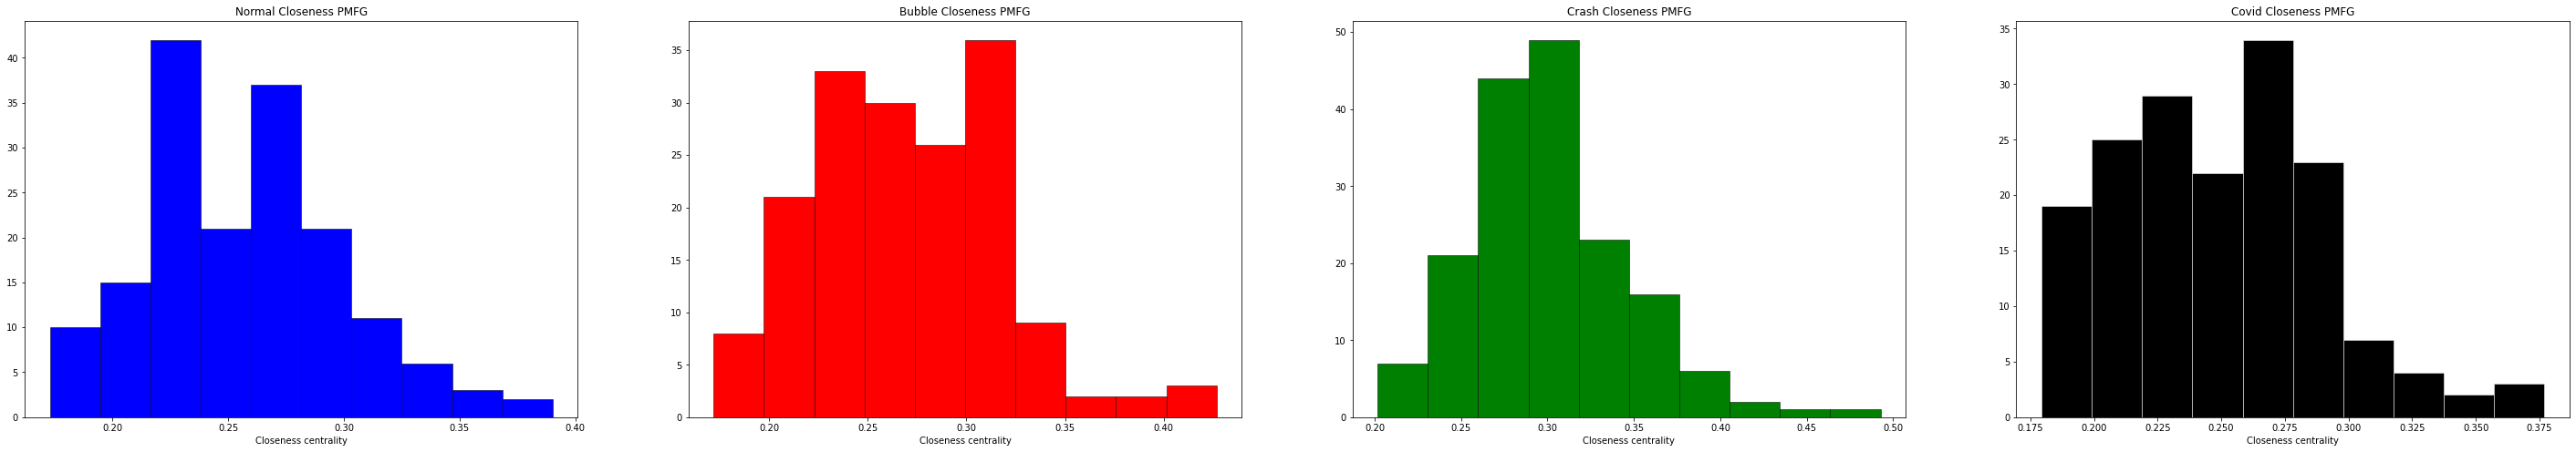

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(50, 8))
ax1.hist(closeness_normal.values(),facecolor = 'blue', edgecolor='black', linewidth=0.5)
ax1.set_title('Normal Closeness PMFG')
ax1.set_xlabel('Closeness centrality')
ax2.hist(closeness_bubble.values(),facecolor = 'red', edgecolor='black', linewidth=0.5)
ax2.set_title('Bubble Closeness PMFG')
ax2.set_xlabel('Closeness centrality')
ax3.hist(closeness_crash.values(),facecolor = 'green', edgecolor='black', linewidth=0.5)
ax3.set_title('Crash Closeness PMFG')
ax3.set_xlabel('Closeness centrality')
ax4.hist(closeness_covid.values(),facecolor = 'black', edgecolor='white', linewidth=0.5)
ax4.set_title('Covid Closeness PMFG')
ax4.set_xlabel('Closeness centrality')
#plt.savefig("plots\\distribution_closeness_PMFG.pdf", format="pdf", bbox_inches="tight")
plt.show()

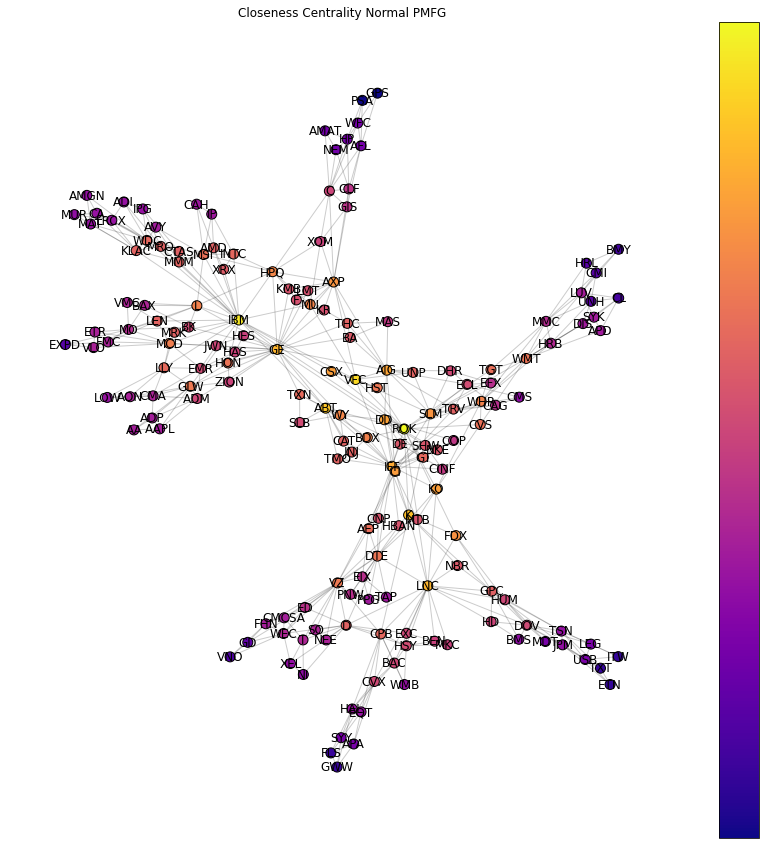

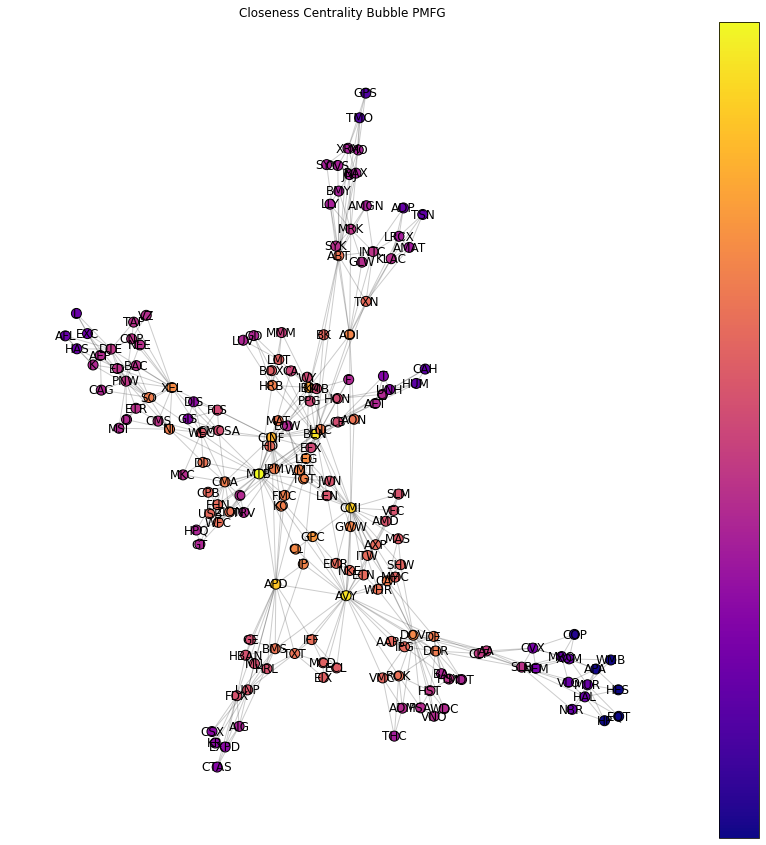

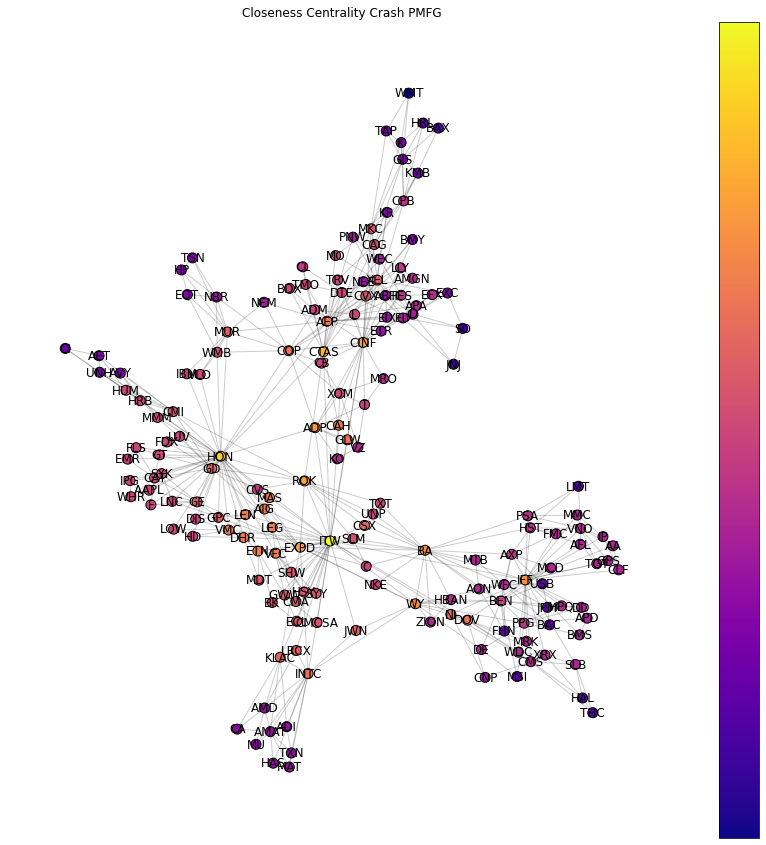

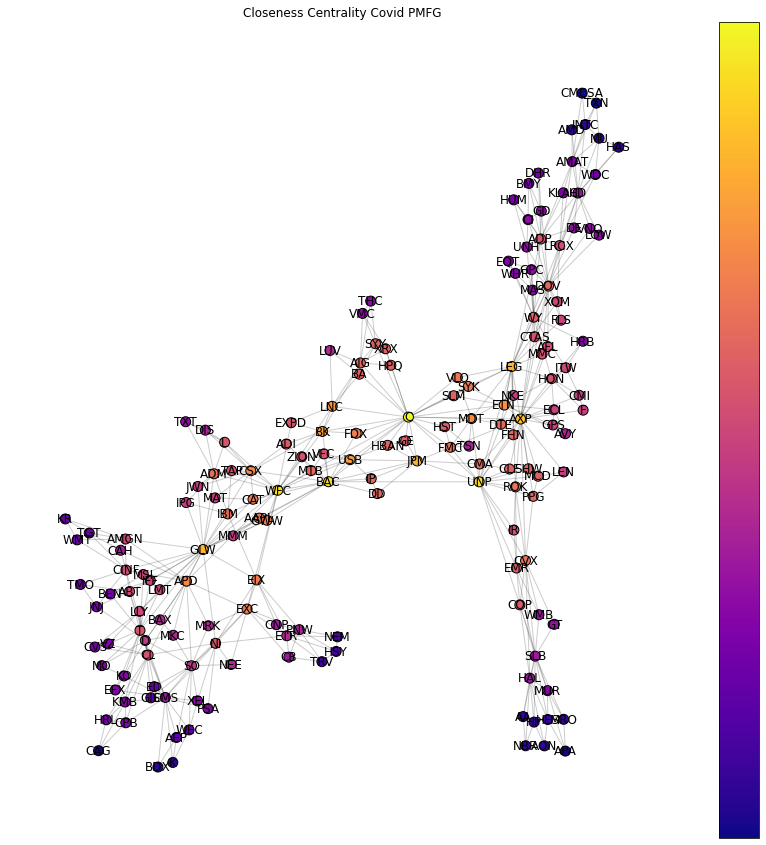

In [113]:
draw_net(list_graph[0], closeness_normal, 'Closeness Centrality Normal PMFG')
draw_net(list_graph[1], closeness_bubble, 'Closeness Centrality Bubble PMFG')
draw_net(list_graph[2], closeness_crash, 'Closeness Centrality Crash PMFG')
draw_net(list_graph[3], closeness_covid, 'Closeness Centrality Covid PMFG')

### Betweenness Centrality

In [20]:
betweenness_normal = nx.betweenness_centrality(list_graph[0])
betweenness_bubble = nx.betweenness_centrality(list_graph[1])
betweenness_crash = nx.betweenness_centrality(list_graph[2])
betweenness_covid = nx.betweenness_centrality(list_graph[3])
betweenness_normal = {k: v for k, v in sorted(betweenness_normal.items(), key=lambda item: item[1],reverse=True)}
betweenness_bubble = {k: v for k, v in sorted(betweenness_bubble.items(), key=lambda item: item[1],reverse=True)}
betweenness_crash = {k: v for k, v in sorted(betweenness_crash.items(), key=lambda item: item[1],reverse=True)}
betweenness_covid = {k: v for k, v in sorted(betweenness_covid.items(), key=lambda item: item[1],reverse=True)}

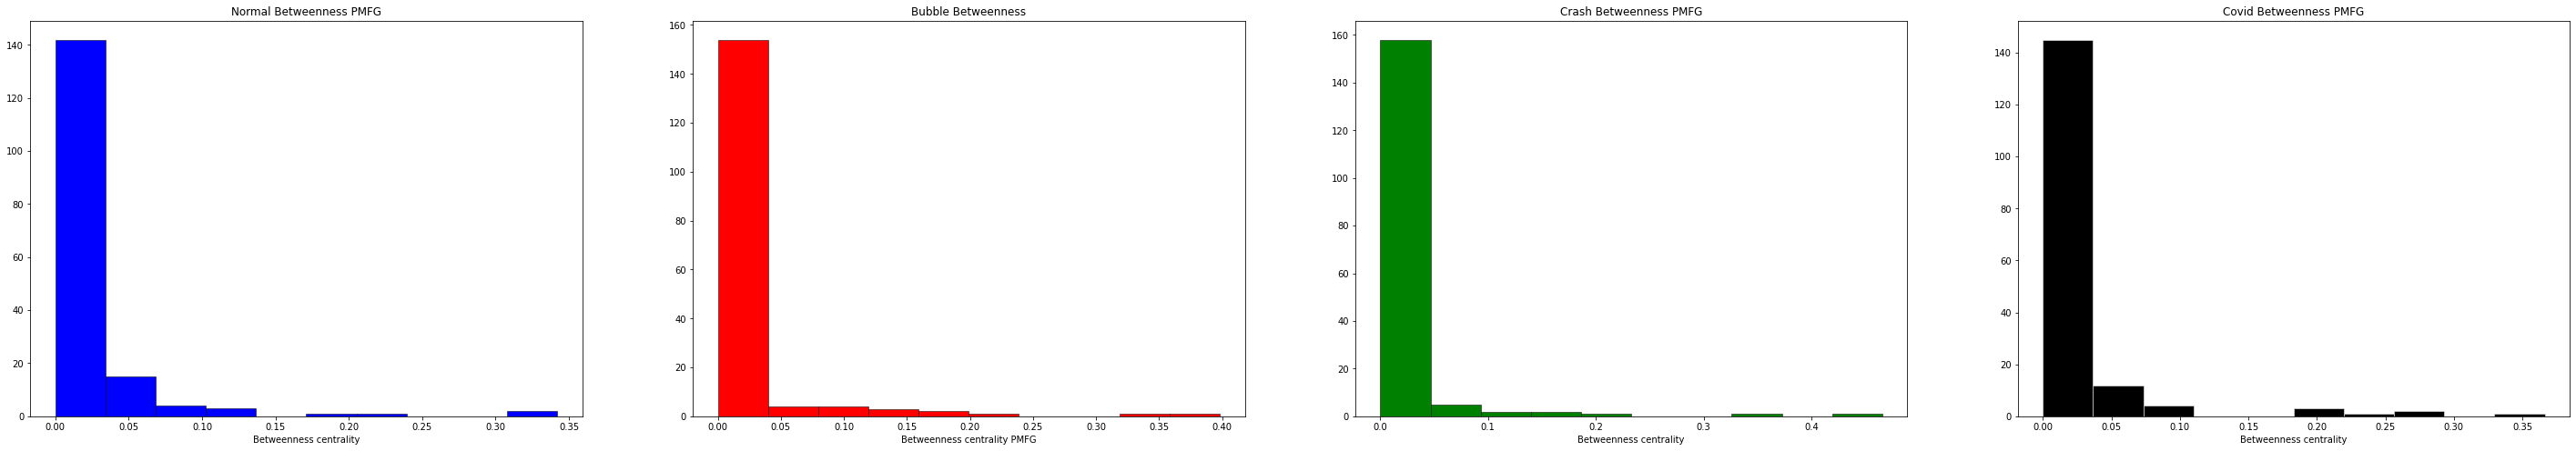

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(50, 8))
ax1.hist(betweenness_normal.values(),facecolor = 'blue', edgecolor='black', linewidth=0.5)
ax1.set_title('Normal Betweenness PMFG')
ax1.set_xlabel('Betweenness centrality')
ax2.hist(betweenness_bubble.values(),facecolor = 'red', edgecolor='black', linewidth=0.5)
ax2.set_title('Bubble Betweenness')
ax2.set_xlabel('Betweenness centrality PMFG')
ax3.hist(betweenness_crash.values(),facecolor = 'green', edgecolor='black', linewidth=0.5)
ax3.set_title('Crash Betweenness PMFG')
ax3.set_xlabel('Betweenness centrality')
ax4.hist(betweenness_covid.values(),facecolor = 'black', edgecolor='white', linewidth=0.5)
ax4.set_title('Covid Betweenness PMFG')
ax4.set_xlabel('Betweenness centrality')
plt.savefig("plots\\distribution_betweenness_PMFG.pdf", format="pdf", bbox_inches="tight")
plt.show()

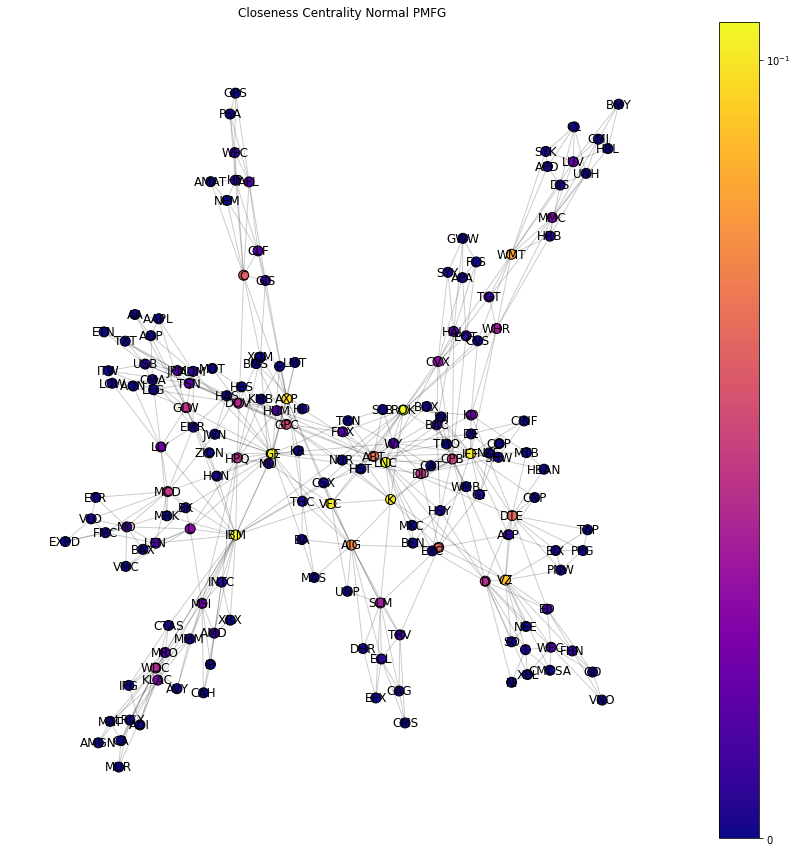

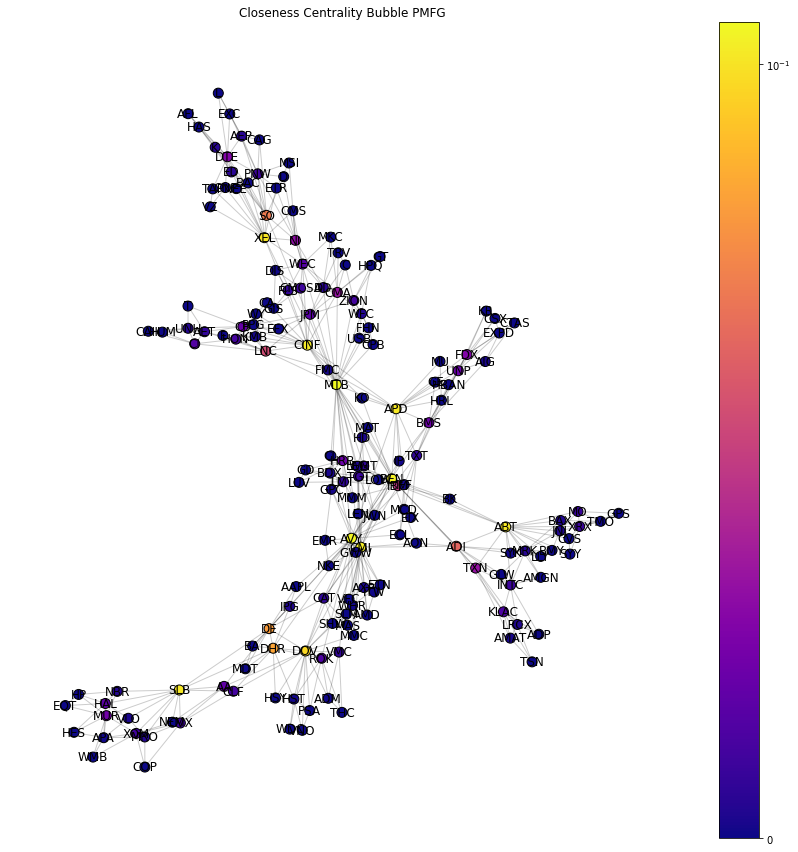

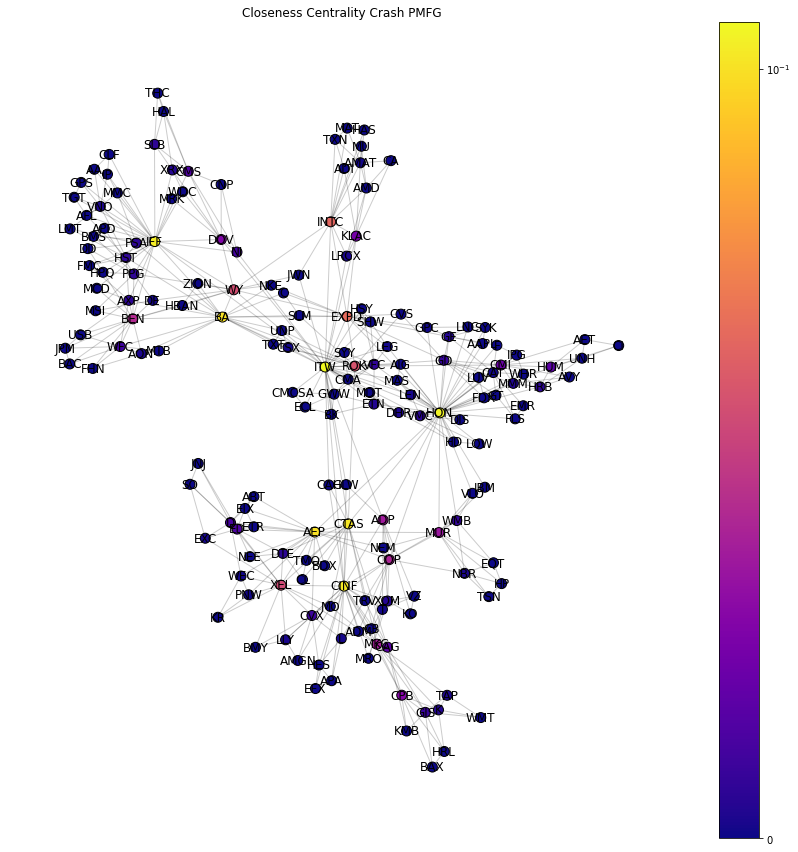

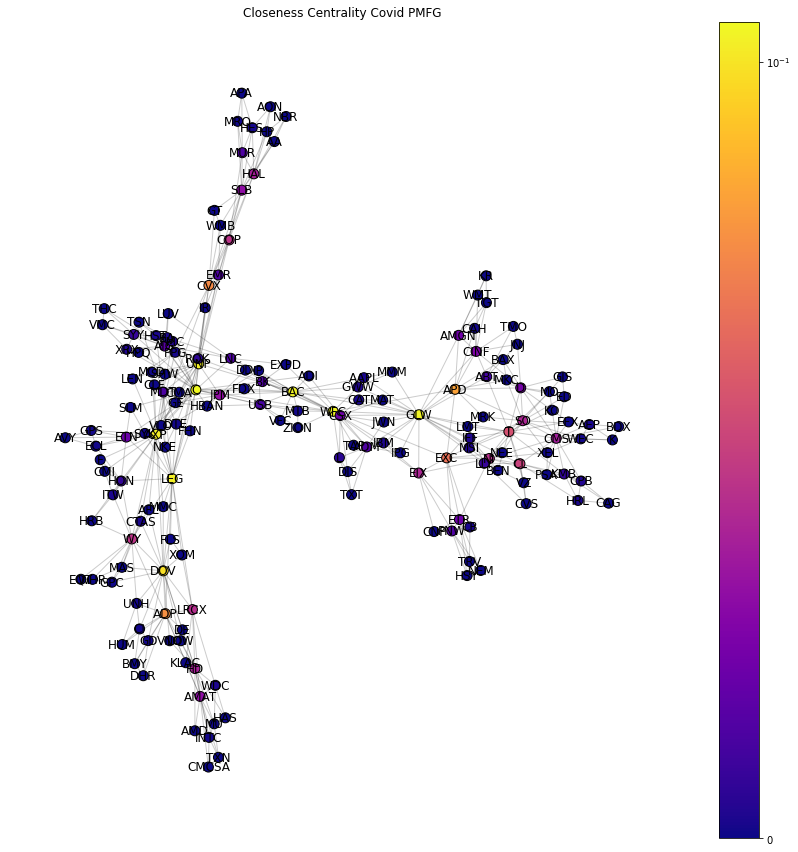

In [116]:
draw_net(list_graph[0], betweenness_normal, 'Closeness Centrality Normal PMFG')
draw_net(list_graph[1], betweenness_bubble, 'Closeness Centrality Bubble PMFG')
draw_net(list_graph[2], betweenness_crash, 'Closeness Centrality Crash PMFG')
draw_net(list_graph[3], betweenness_covid, 'Closeness Centrality Covid PMFG')

### Harmonic Centrality


In [22]:
harmonic_normal = nx.harmonic_centrality(list_graph[0])
harmonic_bubble = nx.harmonic_centrality(list_graph[1])
harmonic_crash = nx.harmonic_centrality(list_graph[2])
harmonic_covid = nx.harmonic_centrality(list_graph[3])
harmonic_normal = {k: v for k, v in sorted(harmonic_normal.items(), key=lambda item: item[1],reverse=True)}
harmonic_bubble = {k: v for k, v in sorted(harmonic_bubble.items(), key=lambda item: item[1],reverse=True)}
harmonic_crash = {k: v for k, v in sorted(harmonic_crash.items(), key=lambda item: item[1],reverse=True)}
harmonic_covid = {k: v for k, v in sorted(harmonic_covid.items(), key=lambda item: item[1],reverse=True)}

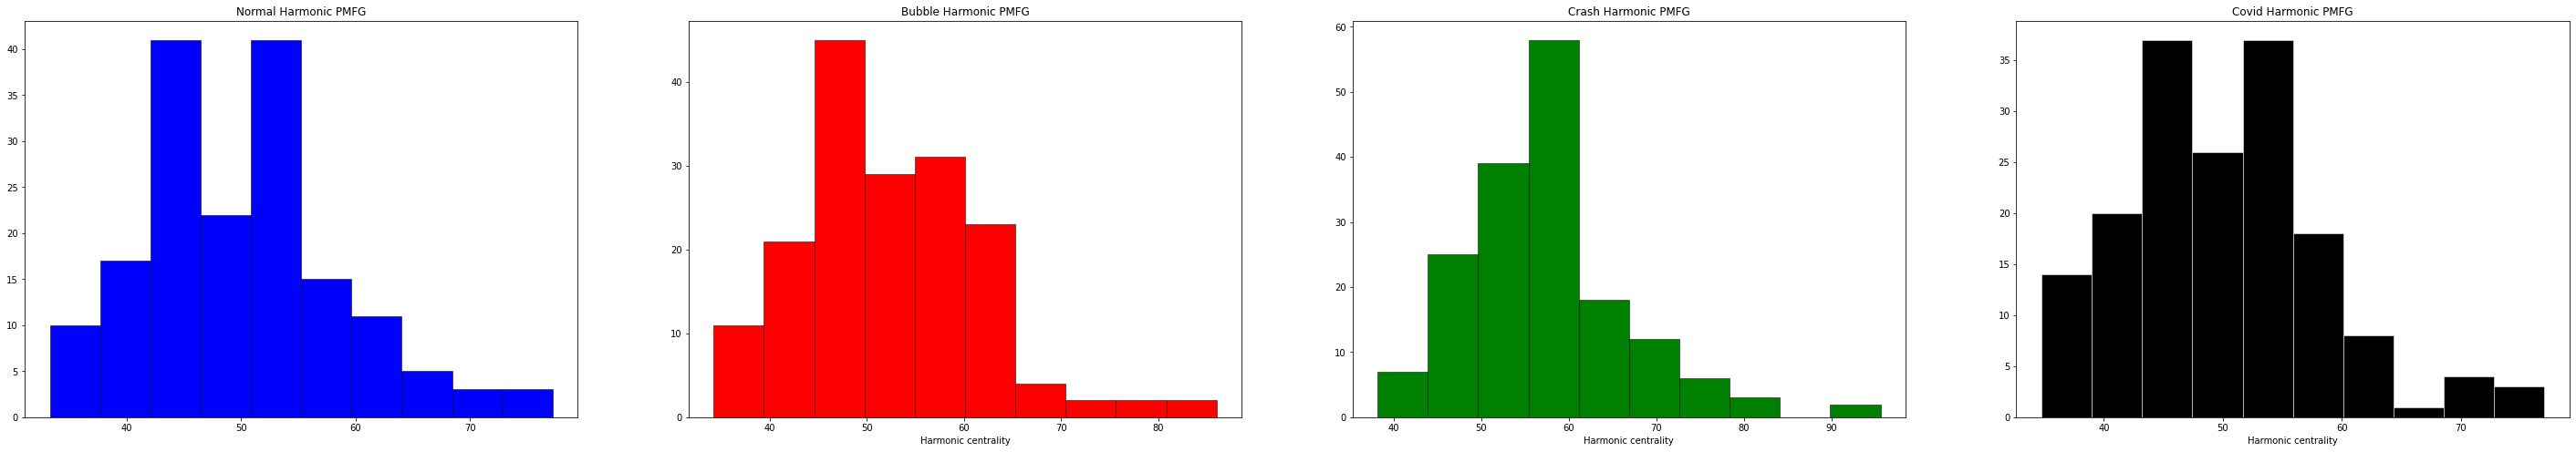

In [23]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(50, 8))
ax1.hist(harmonic_normal.values(),facecolor = 'blue', edgecolor='black', linewidth=0.5)
ax1.set_title('Normal Harmonic PMFG')
ax2.set_xlabel('Harmonic centrality')
ax2.hist(harmonic_bubble.values(),facecolor = 'red', edgecolor='black', linewidth=0.5)
ax2.set_title('Bubble Harmonic PMFG')
ax2.set_xlabel('Harmonic centrality')
ax3.hist(harmonic_crash.values(),facecolor = 'green', edgecolor='black', linewidth=0.5)
ax3.set_title('Crash Harmonic PMFG')
ax3.set_xlabel('Harmonic centrality')
ax4.hist(harmonic_covid.values(),facecolor = 'black', edgecolor='white', linewidth=0.5)
ax4.set_title('Covid Harmonic PMFG')
ax4.set_xlabel('Harmonic centrality')
plt.savefig("plots\\distribution_harmonic_PMFG.pdf", format="pdf", bbox_inches="tight")
plt.show()

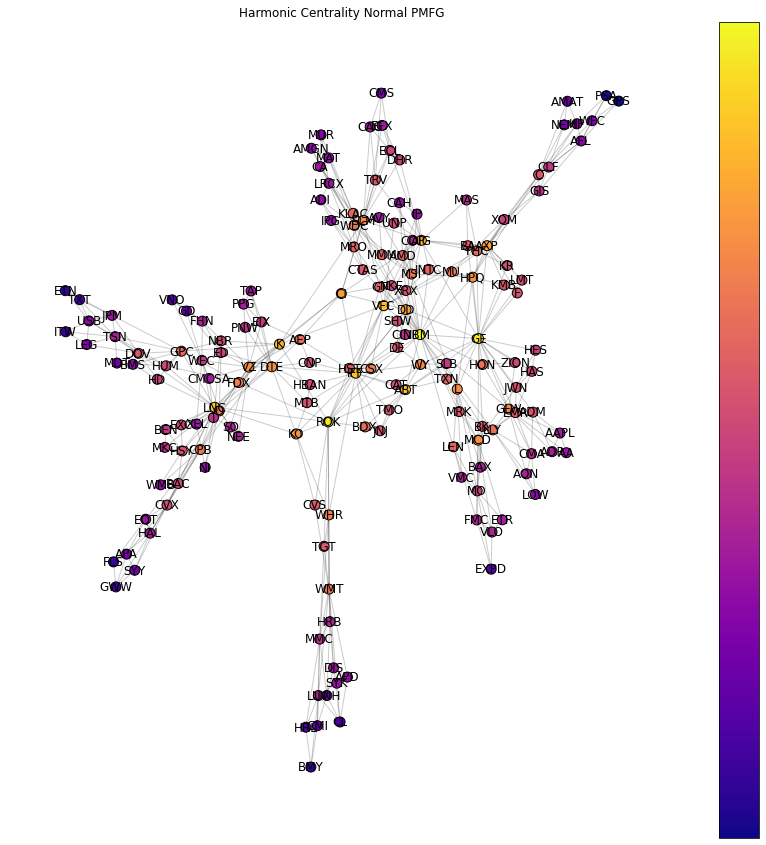

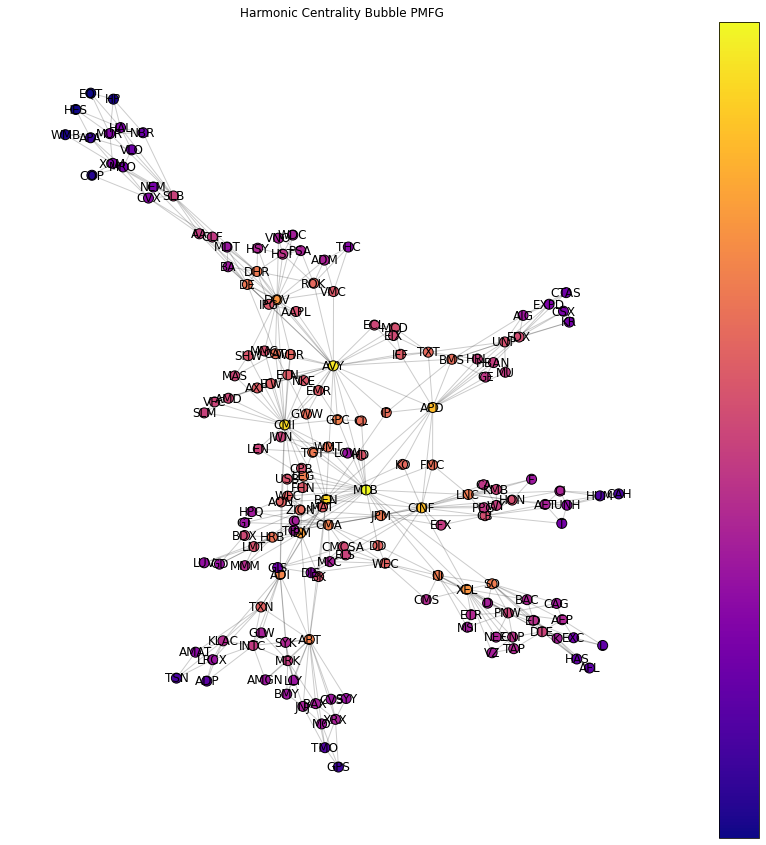

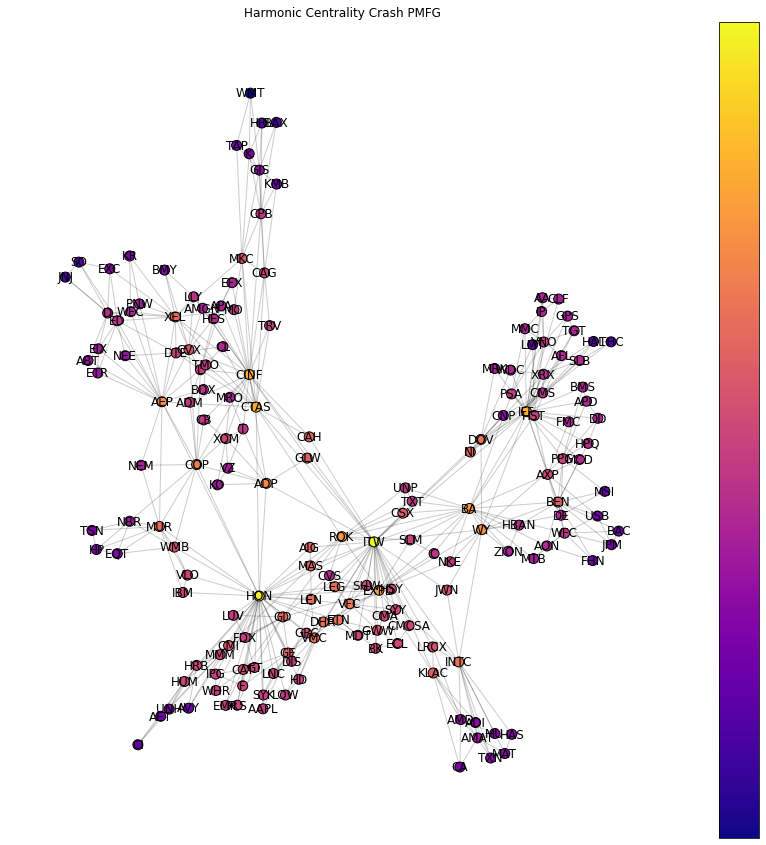

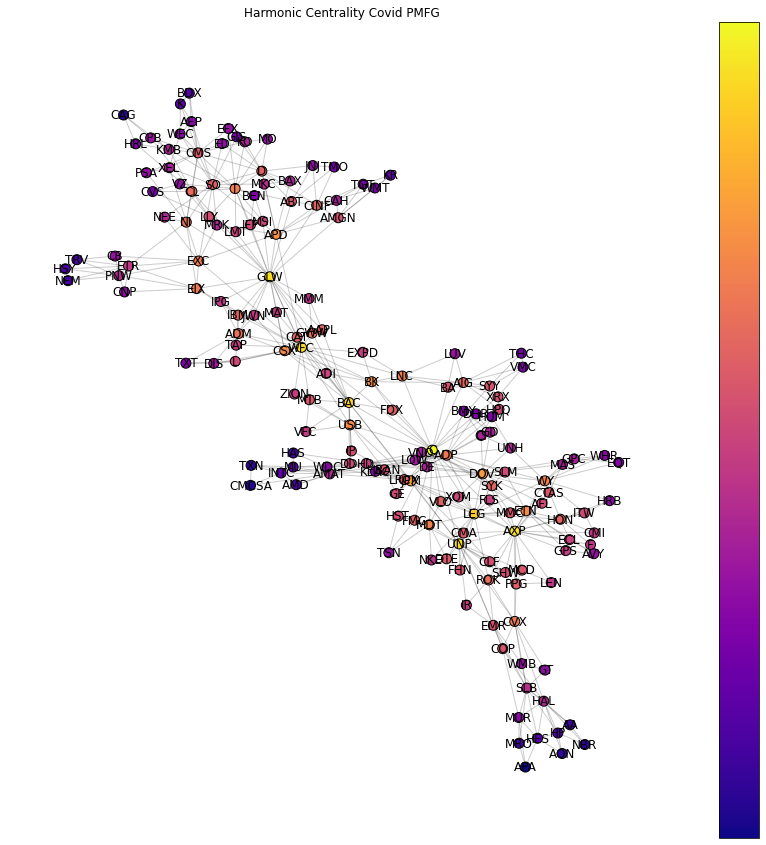

In [24]:
draw_net(list_graph[0], harmonic_normal, 'Harmonic Centrality Normal PMFG')
draw_net(list_graph[1], harmonic_bubble, 'Harmonic Centrality Bubble PMFG')
draw_net(list_graph[2], harmonic_crash, 'Harmonic Centrality Crash PMFG')
draw_net(list_graph[3], harmonic_covid, 'Harmonic Centrality Covid PMFG')

### Eigenvector

In [25]:
eigen_normal = nx.eigenvector_centrality(list_graph[0])
eigen_bubble = nx.eigenvector_centrality(list_graph[1])
eigen_crash = nx.eigenvector_centrality(list_graph[2])
eigen_covid = nx.eigenvector_centrality(list_graph[3])

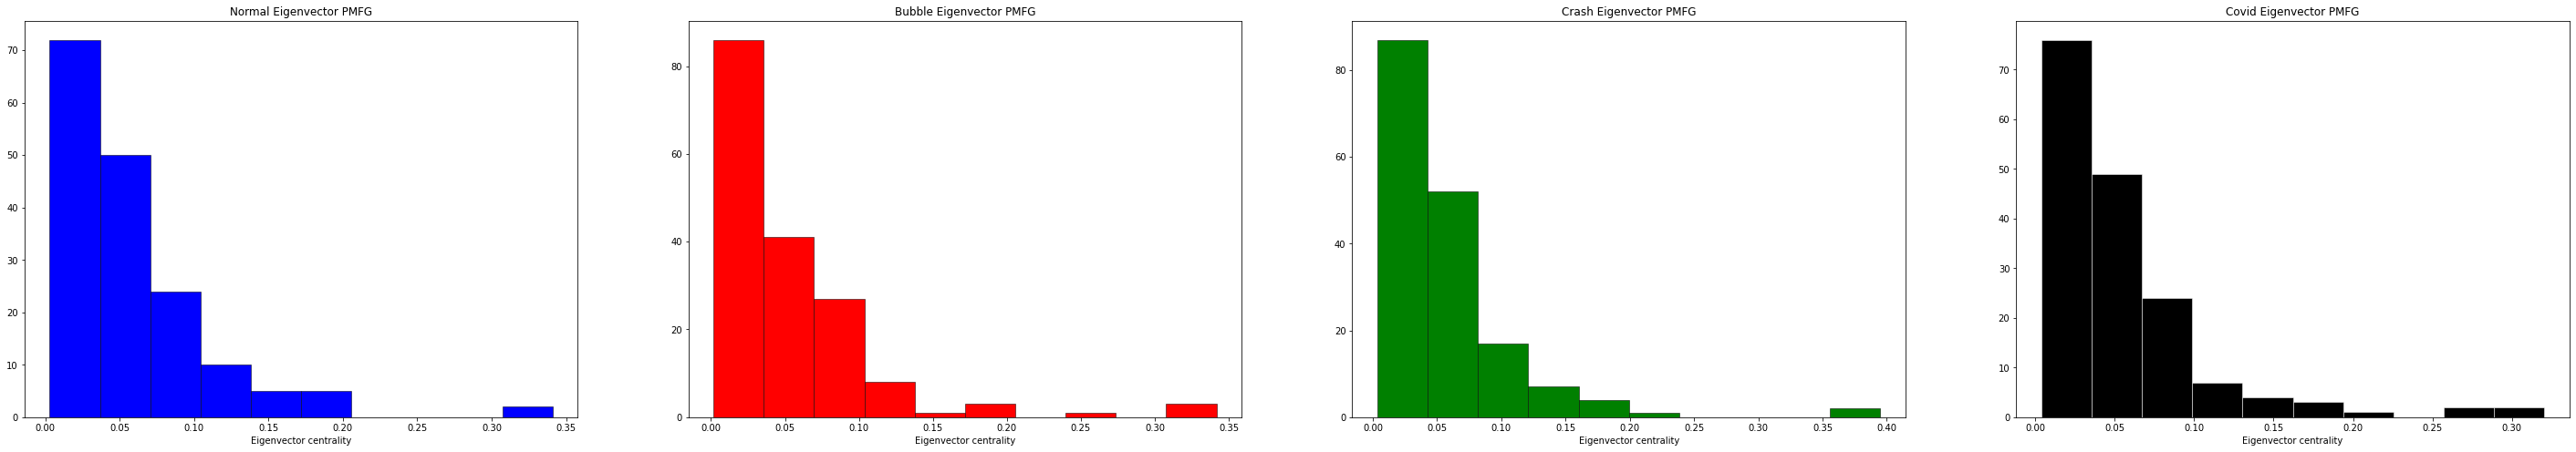

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(50, 8))
ax1.hist(eigen_normal.values(),facecolor = 'blue', edgecolor='black', linewidth=0.5)
ax1.set_title('Normal Eigenvector PMFG')
ax1.set_xlabel('Eigenvector centrality')
ax2.hist(eigen_bubble.values(),facecolor = 'red', edgecolor='black', linewidth=0.5)
ax2.set_title('Bubble Eigenvector PMFG')
ax2.set_xlabel('Eigenvector centrality')
ax3.hist(eigen_crash.values(),facecolor = 'green', edgecolor='black', linewidth=0.5)
ax3.set_title('Crash Eigenvector PMFG')
ax3.set_xlabel('Eigenvector centrality')
ax4.hist(eigen_covid.values(),facecolor = 'black', edgecolor='white', linewidth=0.5)
ax4.set_title('Covid Eigenvector PMFG')
ax4.set_xlabel('Eigenvector centrality')
plt.savefig("plots\\distribution_eigen_PMFG.pdf", format="pdf", bbox_inches="tight")
plt.show()

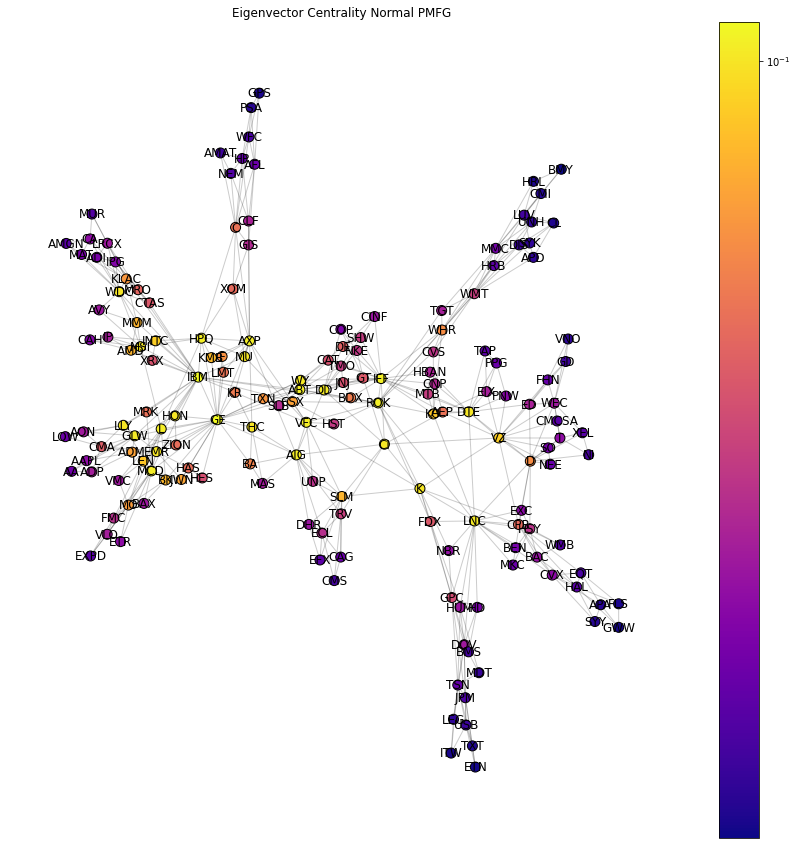

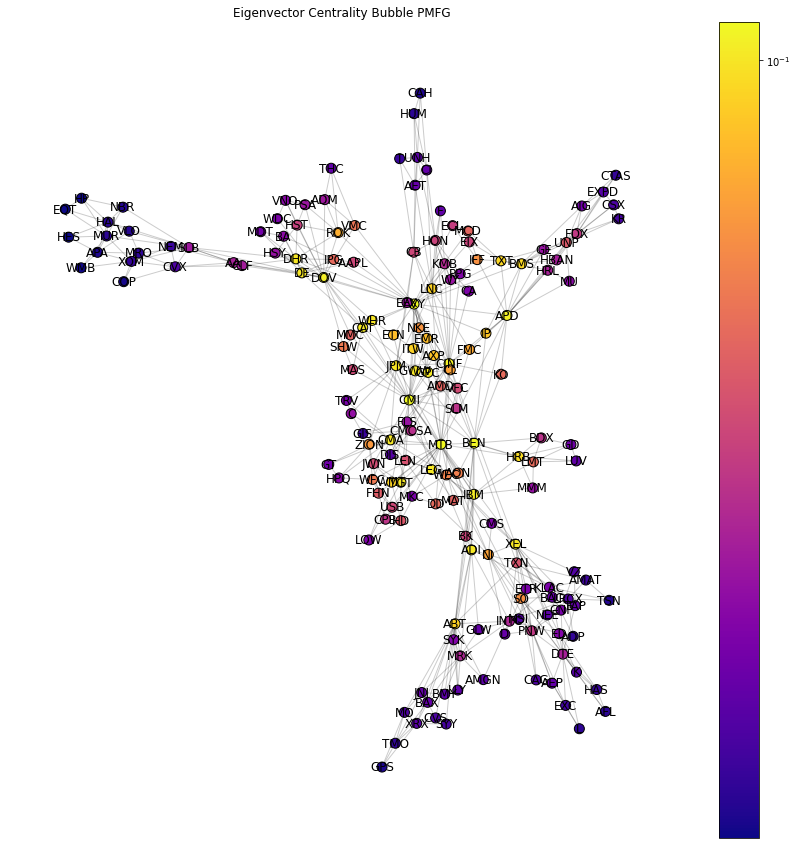

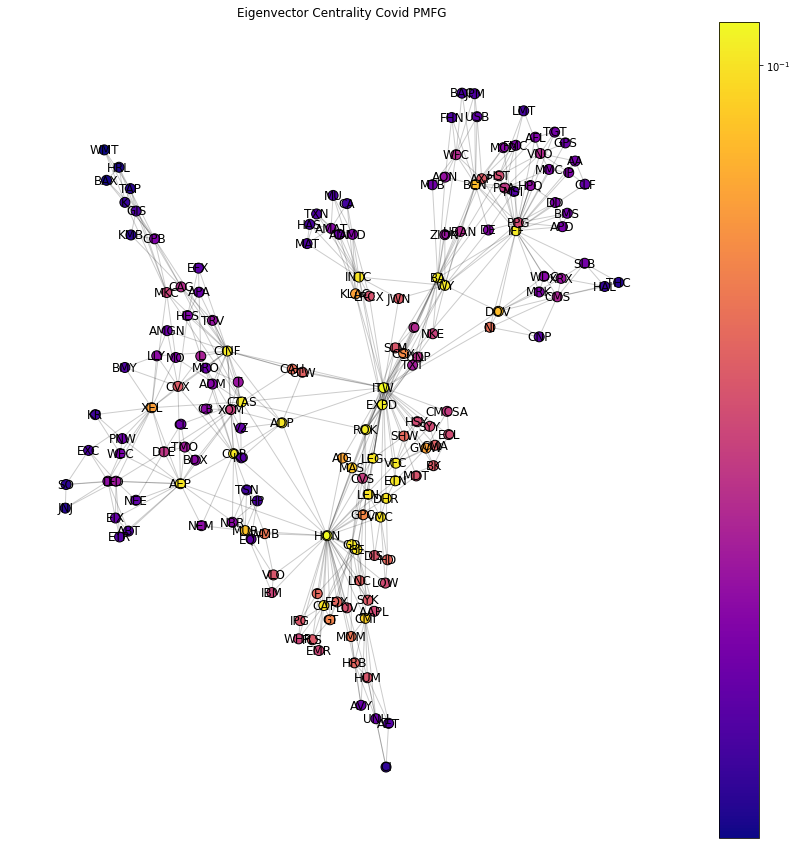

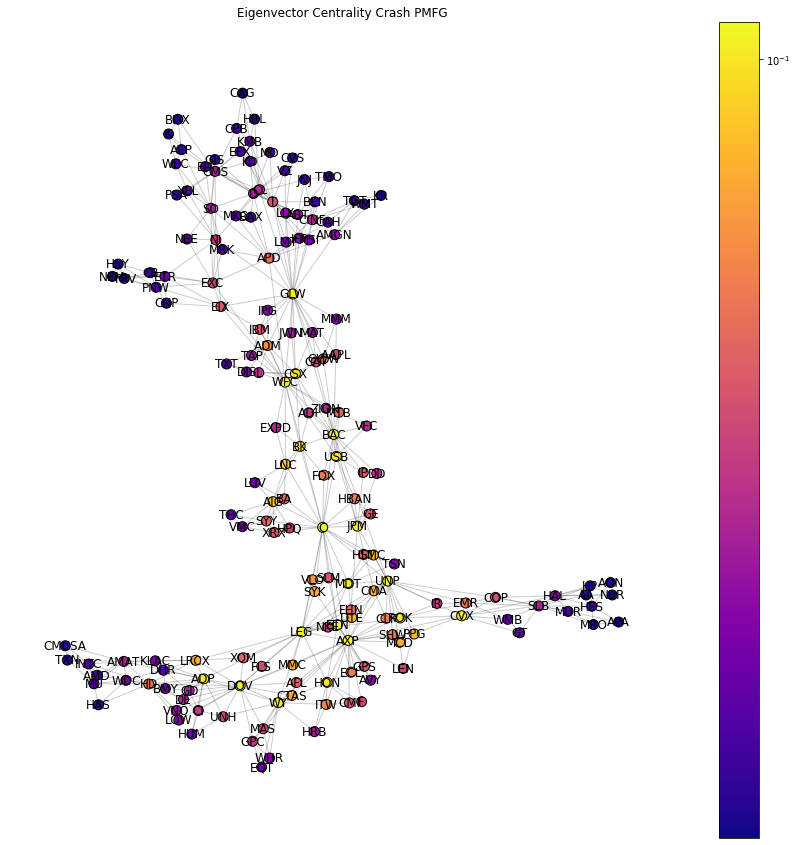

In [124]:
draw_net(list_graph[0], eigen_normal, 'Eigenvector Centrality Normal PMFG')
draw_net(list_graph[1], eigen_bubble, 'Eigenvector Centrality Bubble PMFG')
draw_net(list_graph[2], eigen_crash, 'Eigenvector Centrality Covid PMFG')
draw_net(list_graph[3], eigen_covid, 'Eigenvector Centrality Crash PMFG')

In [27]:
print(f'Normal assortativity:{nx.degree_assortativity_coefficient(list_graph[0]):.2f}' 
      f'\t Bubble assortativity:{nx.degree_assortativity_coefficient(list_graph[1]):.2f}'
      f'\t Crash assortativity:{nx.degree_assortativity_coefficient(list_graph[2]):.2f}'
      f'\t Covid assortativity:{nx.degree_assortativity_coefficient(list_graph[3]):.2f}')

Normal assortativity:-0.06	 Bubble assortativity:-0.06	 Crash assortativity:-0.13	 Covid assortativity:-0.09
